In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


# Chargement des fichiers
bikes_df = pd.read_csv('/content/bikes.csv', delimiter=';')
bikeshops_df = pd.read_csv('/content/bikeshops.csv', delimiter=';')
orders_df = pd.read_csv('/content/orders.csv', delimiter=';')
customers_df = pd.read_csv('/content/Customers.csv', delimiter=',')

In [ ]:
# Jointure entre les commandes (orders) et les vélos (bikes) sur 'product.id' et 'bike.id'
orders_bikes_df = pd.merge(orders_df, bikes_df, left_on='product.id', right_on='bike.id')


In [ ]:
orders_bikes_df['ID'] = range(1, len(orders_bikes_df) + 1)
orders_bikes_df= orders_bikes_df.reset_index(drop=True)
orders_bikes_df = orders_bikes_df.set_index('ID')
orders_bikes_df = orders_bikes_df.drop(columns=['Unnamed: 0'])



In [ ]:
# Jointure entre les commandes (orders) et  les clients (customers) sur 'product.id' et 'bike.id'
orders_customers_df = pd.merge(orders_df, customers_df, left_on='customer.id', right_on='CustomerKey', how='left')


In [ ]:
# Jointure entre les deux tables résultantes sur 'order.id', 'order.line','order.date','product.id
df_merged = pd.merge(orders_customers_df, orders_bikes_df, on=['order.id', 'order.line','order.date','product.id'], how='inner')

In [ ]:
df_merged = df_merged.T.drop_duplicates().T
df_merged = df_merged.drop(columns=['Unnamed: 0'])
df=df_merged

Traitement des valeurs manquantes

In [ ]:
data = df

# Vérification des valeurs manquantes dans le dataset
missing_values_summary = data.isnull().sum()

# Création d'un DataFrame pour afficher les colonnes avec des valeurs manquantes et leur pourcentage
missing_values_df = pd.DataFrame({
    'Column': missing_values_summary.index,
    'Missing Values': missing_values_summary.values,
    'Percentage': (missing_values_summary.values / len(data)) * 100
})

# Filtrage pour afficher seulement les colonnes ayant des valeurs manquantes
missing_values_filtered = missing_values_df[missing_values_df['Missing Values'] > 0]
print("Résumé des valeurs manquantes :")
print(missing_values_filtered)

# Identification des colonnes numériques et catégorielles
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Imputation des colonnes numériques (avec la moyenne) et des colonnes catégorielles (avec le mode)
for col in numeric_cols:
    if col in missing_values_filtered['Column'].values:
        data[col].fillna(data[col].mean(), inplace=True)

for col in categorical_cols:
    if col in missing_values_filtered['Column'].values:
        data[col].fillna(data[col].mode()[0], inplace=True)


Résumé des valeurs manquantes :
Empty DataFrame
Columns: [Column, Missing Values, Percentage]
Index: []


Traitement des doublons

In [ ]:
print(f"Nombre de doublons avant suppression : {data.duplicated().sum()}")


Nombre de doublons avant suppression : 0


Traitement des valeurs abberantes

In [ ]:
# Définition d'une fonction qui détecte les valeurs aberrantes en utilisant l'écart interquartile (IQR)
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # Premier quartile
    Q3 = df[column].quantile(0.75)  # Troisième quartile
    IQR = Q3 - Q1  # Écart interquartile

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identification des valeurs aberrantes
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return outliers

# Vérification des valeurs aberrantes dans la colonne 'price'
price_outliers = detect_outliers(data, 'price')
print(f"Nombre de valeurs aberrantes dans 'price' : {len(price_outliers)}")

# Vérification des valeurs aberrantes dans la colonne 'quantity_x'
quantity_outliers = detect_outliers(data, 'quantity_x')
print(f"Nombre de valeurs aberrantes dans 'quantity_x' : {len(quantity_outliers)}")

# Filtrage des données aberrantes en excluant les valeurs en dehors des bornes
data_filtered = data[
    (data['price'] >= data['price'].quantile(0.25) - 1.5 * (data['price'].quantile(0.75) - data['price'].quantile(0.25))) &
    (data['price'] <= data['price'].quantile(0.75) + 1.5 * (data['price'].quantile(0.75) - data['price'].quantile(0.25))) &
    (data['quantity_x'] >= data['quantity_x'].quantile(0.25) - 1.5 * (data['quantity_x'].quantile(0.75) - data['quantity_x'].quantile(0.25))) &
    (data['quantity_x'] <= data['quantity_x'].quantile(0.75) + 1.5 * (data['quantity_x'].quantile(0.75) - data['quantity_x'].quantile(0.25)))
]

# Vérification de la taille du dataset après filtrage
print(f"Taille du dataset après filtrage : {data_filtered.shape}")

# Affichage des premières lignes du dataset après le filtrage des valeurs aberrantes
print("\nDataset après filtrage des valeurs aberrantes :")
print(data_filtered.head())
data=data_filtered


Nombre de valeurs aberrantes dans 'price' : 1376
Nombre de valeurs aberrantes dans 'quantity_x' : 2542
Taille du dataset après filtrage : (11935, 23)

Dataset après filtrage des valeurs aberrantes :
  order.id order.line order.date customer.id_x product.id quantity_x  Prefix  \
0        1          1   1/7/2011             2         48          1    Mrs.   
1        1          2   1/7/2011             2         52          1    Mrs.   
2        2          1  1/10/2011            10         76          1     Ms.   
3        2          2  1/10/2011            10         52          1     Ms.   
5        3          2  1/10/2011             6         50          1    Miss   

   FirstName  LastName    BirthDate  ...  AnnualIncome  TotalChildren  \
0      Alice     Smith   02/12/1988  ...         60000              2   
1      Alice     Smith   02/12/1988  ...         60000              2   
2      Fiona      Teal   12/09/1989  ...         46000              1   
3      Fiona      Teal   12/

Encodage des variables catégorielles :

In [ ]:
# Liste des colonnes catégorielles pertinentes
categorical_cols_to_encode = ['category1', 'category2', ' Occupation', ' HomeOwner',
                              ' EducationLevel', ' MaritalStatus', ' Gender', 'frame']

# Encodage de fréquence pour chaque colonne catégorielle pertinente
for col in categorical_cols_to_encode:
    if col in data.columns:
        # Remplacer chaque catégorie par la fréquence d'apparition de la catégorie
        freq_encoding = data[col].value_counts(normalize=True)
        data[col] = data[col].map(freq_encoding)

# Affichage des premières lignes du dataset après encodage
print("\nDataset après encodage de fréquence :")
print(data.head())

# Affichage de la taille du dataset après encodage
print(f"\nTaille du dataset après encodage : {data.shape}")


Dataset après encodage de fréquence :
  order.id order.line order.date customer.id_x product.id quantity_x  Prefix  \
0        1          1   1/7/2011             2         48          1    Mrs.   
1        1          2   1/7/2011             2         52          1    Mrs.   
2        2          1  1/10/2011            10         76          1     Ms.   
3        2          2  1/10/2011            10         52          1     Ms.   
5        3          2  1/10/2011             6         50          1    Miss   

   FirstName  LastName    BirthDate  ...   AnnualIncome   TotalChildren  \
0      Alice     Smith   02/12/1988  ...          60000               2   
1      Alice     Smith   02/12/1988  ...          60000               2   
2      Fiona      Teal   12/09/1989  ...          46000               1   
3      Fiona      Teal   12/09/1989  ...          46000               1   
5       Jane      Blue   14/04/1995  ...          32000               0   

   EducationLevel  Occupation

<ipython-input-12-e1e69120d802>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].map(freq_encoding)
<ipython-input-12-e1e69120d802>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].map(freq_encoding)
<ipython-input-12-e1e69120d802>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

<ipython-input-15-06a961bbe301>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['order.date'] = pd.to_datetime(data['order.date'])


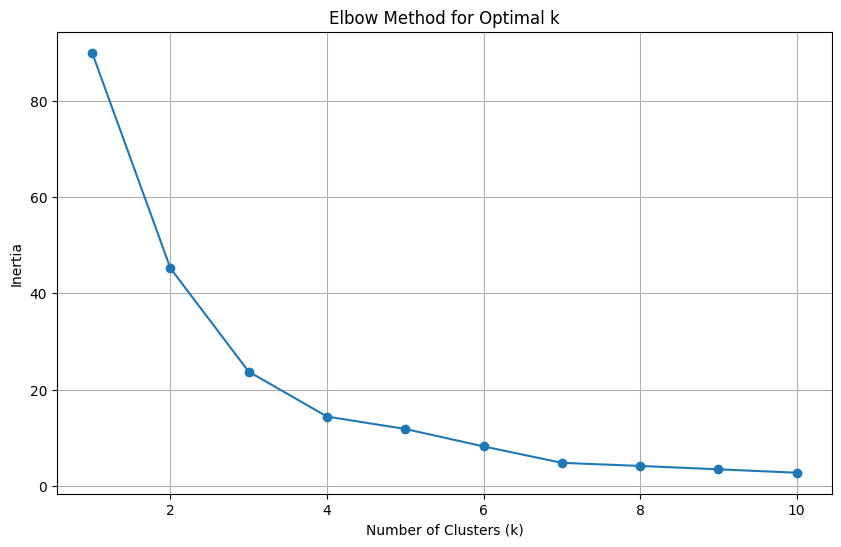

In [ ]:

# Conversion de la colonne 'order.date' en format datetime
data['order.date'] = pd.to_datetime(data['order.date'])

# Détermination de  la date de la dernière commande dans les données
latest_date = data['order.date'].max()

# Créer un DataFrame RFM pour stocker les valeurs
rfm_data = data.groupby('customer.id_x').agg({
    'order.date': lambda x: (latest_date - x.max()).days,  # Récence: nombre de jours depuis la dernière commande
    'order.id': 'nunique',  # Fréquence: nombre total de commandes
    'price': 'sum'  # Montant: somme des montants dépensés
}).reset_index()

# Renommage les colonnes pour plus de clarté
rfm_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Standardisation les données RFM pour que les valeurs soient sur la même échelle
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

# Méthode du coude pour déterminer le nombre optimal de clusters (k)
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Visualisation de la méthode du coude pour trouver le nombre optimal de clusters
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()




In [ ]:
# Choix du nombre de clusters optimal basé sur la méthode du coude (par exemple, k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyser les caractéristiques de chaque cluster
cluster_summary = rfm_data.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'CustomerID': 'count'
}).reset_index()

# Renommer les colonnes pour plus de clarté
cluster_summary.columns = ['Cluster', 'Recency_Mean', 'Recency_Median', 'Frequency_Mean',
                           'Frequency_Median', 'Monetary_Mean', 'Monetary_Median', 'Customer_Count']

# Afficher un aperçu du résumé des clusters
print(cluster_summary)

   Cluster  Recency_Mean  Recency_Median  Frequency_Mean  Frequency_Median  \
0        0     19.894737            21.0       38.210526              34.0   
1        1      2.000000             2.0      334.000000             334.0   
2        2     87.600000            86.0       36.200000              35.0   
3        3      4.200000             3.0      126.400000             115.0   

   Monetary_Mean Monetary_Median  Customer_Count  
0  706196.315789        749035.0              19  
1      5630200.0       5630200.0               1  
2       688317.0        599565.0               5  
3      2374838.0       2179395.0               5  


Silhouette Score: 0.49


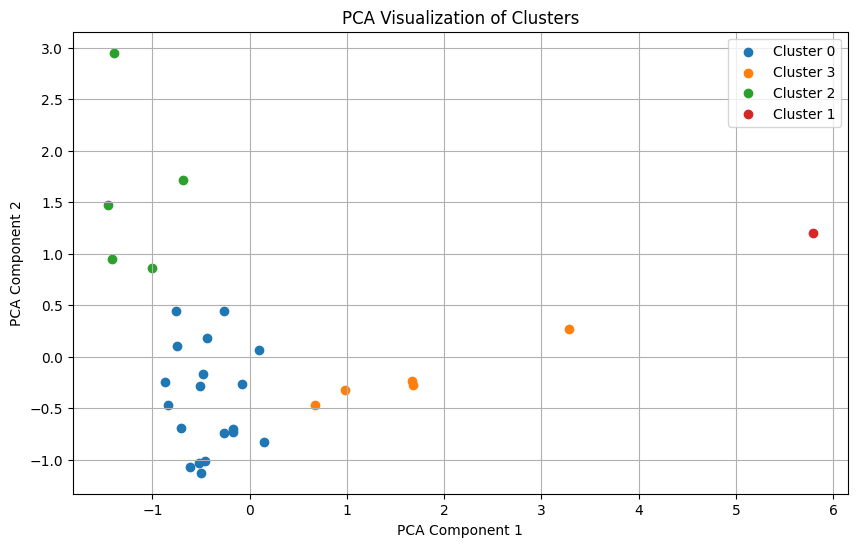

In [ ]:
# Calcul de l'indice de silhouette pour évaluer la qualité des clusters
silhouette_avg = silhouette_score(rfm_scaled, rfm_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Utilisation de PCA pour réduire la dimensionnalité à 2 composantes principales pour visualiser les clusters
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Création d'un DataFrame avec les composantes principales et les clusters
pca_df = pd.DataFrame(data=rfm_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = rfm_data['Cluster']

# Visualisation des clusters
plt.figure(figsize=(10, 6))
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()
